Device Name :  TITAN RTX
The number of devices:  1
Dataset Sizes :  {'train': 1596, 'val': 100, 'test': 100}

Epoch 0/49
----------
train Loss: 0.6747 Acc: 0.6084 F1: 0.2443


/home/yslee/CNN_Prediction_Endo/training_modules.py:99: RuntimeWarning: invalid value encountered in double_scalars
  epoch_f1=(2*epoch_sen*epoch_pre)/(epoch_sen+epoch_pre)


val Loss: 0.6273 Acc: 0.6800 F1: nan

Epoch 1/49
----------
train Loss: 0.6431 Acc: 0.6560 F1: 0.1593
val Loss: 0.6041 Acc: 0.6900 F1: nan

Epoch 2/49
----------
train Loss: 0.6299 Acc: 0.6673 F1: 0.1918
val Loss: 0.6229 Acc: 0.6900 F1: 0.0606

Epoch 3/49
----------
train Loss: 0.6171 Acc: 0.6685 F1: 0.2232
val Loss: 0.6054 Acc: 0.6800 F1: nan

Epoch 4/49
----------
train Loss: 0.5966 Acc: 0.6792 F1: 0.2601
val Loss: 0.5934 Acc: 0.6600 F1: nan

Epoch 5/49
----------
train Loss: 0.5978 Acc: 0.6779 F1: 0.3073
val Loss: 0.6092 Acc: 0.6500 F1: 0.1860

Epoch 6/49
----------
train Loss: 0.5725 Acc: 0.7011 F1: 0.3648
val Loss: 0.6395 Acc: 0.6400 F1: 0.3571

Epoch 7/49
----------
train Loss: 0.5742 Acc: 0.6942 F1: 0.4063
val Loss: 0.6395 Acc: 0.6600 F1: 0.0556

Epoch 8/49
----------
train Loss: 0.5467 Acc: 0.7193 F1: 0.4372
val Loss: 0.6195 Acc: 0.7000 F1: 0.4231

Epoch 9/49
----------
train Loss: 0.5115 Acc: 0.7337 F1: 0.5029
val Loss: 0.6613 Acc: 0.6600 F1: 0.2917

Epoch 10/49
----------
tra

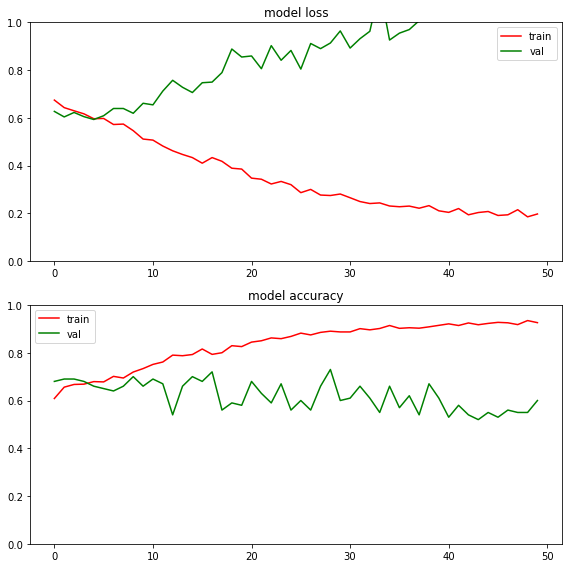

In [7]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from training_modules import get_clinical_features,train_3model2,test_model
from dental_datasets import DentalDataset
from torch import optim
from torch.optim import lr_scheduler
from datetime import datetime
import pandas as pd
import numpy as np
import pandas as pd
from Attention_ResNet import Block, SelfAttention, DownsampleLayer

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv0=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(5,5),stride=(2,2),padding=(2,2),bias=False)
        self.bn=nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.maxpool0=nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.relu=nn.ReLU(inplace=True)

        self.layer1=Block(16,16,maxpool=True)
        self.layer2=Block(16,32,maxpool=False)
        self.layer_downsample1=DownsampleLayer(16,32) #,stride=(1,1)

        #self.attention_dot1=SelfAttention_dot(32)
        self.attention_matmul=SelfAttention(32)

        self.layer3=Block(32,32,maxpool=True)
        self.layer4=Block(32,64,maxpool=False)
        self.layer_downsample2=DownsampleLayer(32,64)

        self.layer5=Block(64,64,maxpool=True)
        self.layer6=Block(64,128,maxpool=False)
        self.layer_downsample3=DownsampleLayer(64,128)

        self.layer7=Block(128,128,maxpool=False)
        self.layer8=Block(128,256,maxpool=False)
        self.layer_downsample4=DownsampleLayer(128,256,stride=(1,1)) #

        #self.attention_dot2=SelfAttention_dot(256)

        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*1*1,256*1*1//2,bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256*1*1//2,2,bias=True)
        )
        '''nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64*3*3,2,bias=True)'''

    def forward(self,x):
        x=self.conv0(x)
        x=self.bn(x)
        x=self.maxpool0(x)
        x=self.relu(x)

        layer_identity1=x
        x=self.layer1(x)
        x=self.layer2(x)
        #layer_identity1=F.interpolate(layer_identity1,size=(76,76))
        x=x.clone()+self.layer_downsample1(layer_identity1)

        '''x=self.attention_dot1(x)
        x=self.relu(x)'''
        #attention_identity=x
        x=self.attention_matmul(x)
        #x+=attention_identity
        x=self.relu(x)

        layer_identity2=x
        x=self.layer3(x)
        x=self.layer4(x)
        #layer_identity2=F.interpolate(layer_identity2,scale_factor=0.5)
        x=x.clone()+self.layer_downsample2(layer_identity2)     

        layer_identity3=x
        x=self.layer5(x)
        x=self.layer6(x)
        #layer_identity3=F.interpolate(layer_identity3,scale_factor=0.5)
        x=x.clone()+self.layer_downsample3(layer_identity3)

        layer_identity4=x
        x=self.layer7(x)
        x=self.layer8(x)
        #layer_identity4=F.interpolate(layer_identity4,size=(10,10))
        x=x.clone()+self.layer_downsample4(layer_identity4)

        '''x=self.attention_dot2(x)
        x=self.relu(x)'''

        x=self.avgpool(x)
        x=x.view(-1,self.num_flat_features(x))
        x=self.fc(x)

        return x

    def num_flat_features(self,x):
        size=x.size()[1:]
        num_features=1
        for s in size:
            num_features*=s
        
        return num_features

##Path##
split_path='/home/NAS_mount/yslee/dataset/crossval_dataset3-1103flip'
train_path=os.path.join(split_path,'train')
val_path=os.path.join(split_path,'val')
test_path=os.path.join(split_path,'test')

##Define dataset, dataloaders##
org_dic = np.load('/home/NAS_mount/yslee/dataset/org_dic_1101.npy',allow_pickle='TRUE').item()
#grad_dic = np.load('/home/NAS_mount/yslee/dataset/toothclass2_graddic.npy',allow_pickle='TRUE').item()
grad_dic = np.load('/home/NAS_mount/yslee/dataset/toothclass3_grad_dic.npy',allow_pickle='TRUE').item()

label_file=pd.read_csv('/home/NAS_mount/yslee/dataset/premolar_labels_0810.csv')
#label_file=pd.read_csv('/home/NAS_mount/yslee/dataset/premolar_labels_1124.csv')
label_file=label_file.set_index('PatientID_new')
label_file=label_file['Result']
#label_file=label_file['tooth_class']

preprocessed_mean=0.59
preprocessed_std=0.24
org_mean=0.70
org_std=0.20
grad_mean=0.30
grad_std=0.20

data_normalization={'preprocessed': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((preprocessed_mean,), (preprocessed_std,))
]),
    'original': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((org_mean,), (org_std,))
]),
    'grad': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((grad_mean,), (grad_std,))
])
}

dataset={'train': DentalDataset(preprocessed_dir=train_path,org_dic=org_dic,label_file=label_file,normalize=data_normalization,augmentation=True,grad_dic=grad_dic,grad_dic2=None),
            'val': DentalDataset(preprocessed_dir=val_path,org_dic=org_dic,label_file=label_file,normalize=data_normalization,augmentation=False,grad_dic=grad_dic,grad_dic2=None),
            'test': DentalDataset(preprocessed_dir=test_path,org_dic=org_dic,label_file=label_file,normalize=data_normalization,augmentation=False,grad_dic=grad_dic,grad_dic2=None)}

dataloaders={'train': torch.utils.data.DataLoader(dataset['train'],batch_size=20,shuffle=True),
                'val':torch.utils.data.DataLoader(dataset['val'],batch_size=20,shuffle=True),
                'test':torch.utils.data.DataLoader(dataset['test'],batch_size=20,shuffle=False)}

dataset_sizes = {'train': dataset['train'].__len__(),
                    'val':dataset['val'].__len__(),
                    'test':dataset['test'].__len__()}

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="4"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Name : ',torch.cuda.get_device_name(device))
print('The number of devices: ',torch.cuda.device_count())
print('Dataset Sizes : ',dataset_sizes)
print()

##Define model, loss, optimizer, scheduler##
model=Net()
#model.load_state_dict(torch.load('/home/NAS_mount/yslee/dataset/models/transfer_learning/toothclass2_later_crossval3_11-24-04:55.pt', map_location={"cuda" : "cpu"}))

model=nn.DataParallel(model)
model=model.to(device)

learning_rate=0.00005 #0.0001 #0.001 #0.00001 #feature classification: 0.00005
criterion = nn.CrossEntropyLoss()#weight=torch.tensor([1.,1.8],device='cuda')
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #,weight_decay=0.001
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) #gamma=0.2

accf1model, accf1model_later, accmodel, accmodel_later, f1model, f1model_later= train_3model2(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=50, file_name='transfer_learning/attenetwithCAM_cv3')

torch.save(accf1model.module.state_dict(),'/home/NAS_mount/yslee/dataset/models/transfer_learning/'+'ACCF1attenetwithCAM_cv3_'+datetime.today().strftime('%m-%d-%H:%M')+'.pt')
torch.save(accf1model_later.module.state_dict(),'/home/NAS_mount/yslee/dataset/models/transfer_learning/'+'ACCF1attenetwithCAM_later_cv3_'+datetime.today().strftime('%m-%d-%H:%M')+'.pt')

torch.save(accmodel.module.state_dict(),'/home/NAS_mount/yslee/dataset/models/transfer_learning/'+'ACCattenetwithCAM_cv3_'+datetime.today().strftime('%m-%d-%H:%M')+'.pt')
torch.save(accmodel_later.module.state_dict(),'/home/NAS_mount/yslee/dataset/models/transfer_learning/'+'ACCattenetwithCAM_later_cv3_'+datetime.today().strftime('%m-%d-%H:%M')+'.pt')

torch.save(f1model.module.state_dict(),'/home/NAS_mount/yslee/dataset/models/transfer_learning/'+'F1attenetwithCAM_cv3_'+datetime.today().strftime('%m-%d-%H:%M')+'.pt')
torch.save(f1model_later.module.state_dict(),'/home/NAS_mount/yslee/dataset/models/transfer_learning/'+'F1attenetwithCAM_later_cv3_'+datetime.today().strftime('%m-%d-%H:%M')+'.pt')

device_cpu=torch.device('cpu')

acc5,confusion_matrix5=test_model(accf1model,dataloaders,device_cpu)
acc6,confusion_matrix6=test_model(accf1model_later,dataloaders,device_cpu)

acc1,confusion_matrix1=test_model(accmodel,dataloaders,device_cpu)
acc2,confusion_matrix2=test_model(accmodel_later,dataloaders,device_cpu)

acc3,confusion_matrix3=test_model(f1model,dataloaders,device_cpu)
acc4,confusion_matrix4=test_model(f1model_later,dataloaders,device_cpu)

In [3]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

def test_score(model,dataloaders,device):
    CM=0

    model.eval()
    score_df=pd.DataFrame()
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels, file_name = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images) #file_name
            preds = torch.argmax(outputs.data, 1)
            
            filename_df=pd.DataFrame(file_name)
            outputs_df=pd.DataFrame(np.array(F.softmax(outputs)))
            preds_df=pd.DataFrame(preds)
            labels_df=pd.DataFrame(labels)
            
            concat_df=pd.concat([filename_df,outputs_df,preds_df,labels_df],axis=1)

            CM+=confusion_matrix(labels.cpu(), preds.cpu(),labels=[0,1])
            score_df=pd.concat([score_df,concat_df],axis=0)
            
        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]

        acc=np.sum(np.diag(CM)/np.sum(CM))
        
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        print()
        print('Confusion Matirx : ')
        print(CM)
        print('- Sensitivity : ',(tp/(tp+fn))*100)
        print('- Specificity : ',(tn/(tn+fp))*100)
        print()

        score_df.columns=['PatientID','success_score','fail_score','prediction','label']
    return score_df

In [6]:
device_cpu=torch.device('cpu')
'''model=torchvision.models.resnet18(pretrained=False)
model.conv1=nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc=nn.Linear(in_features=512, out_features=2, bias=True)'''
'''model=torchvision.models.vgg16(pretrained=False)
model.features[0]=nn.Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.classifier[6]=nn.Linear(in_features=4096, out_features=2, bias=True)'''
model=Net()

model.load_state_dict(torch.load('/home/NAS_mount/yslee/dataset/models/transfer_learning/F1attenetwithCAM_cv3_11-24-15:22.pt', map_location={"cuda" : "cpu"}))
model=model.to(device_cpu)
model.eval()

Net17_score=test_score(model,dataloaders,device_cpu)

/home/yslee/tmp/conda/envs/cuda_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Testset Accuracy(mean): 56.000000 %

Confusion Matirx : 
[[47 23]
 [21  9]]
- Sensitivity :  30.0
- Specificity :  67.14285714285714



In [5]:
Net17_score.to_csv('/home/NAS_mount/yslee/dataset/score/F1attenetwithCAM_score.csv',index=False)

In [5]:
device_cpu=torch.device('cpu')
model=Net()

model.load_state_dict(torch.load('/home/NAS_mount/yslee/dataset/models/nonflip/F1crossval2_later_11-15-01:06.pt', map_location={"cuda" : "cpu"}))
model=model.to(device_cpu)
model.eval()

Net17_score=test_score(model,dataloaders,device_cpu)

/home/yslee/tmp/conda/envs/cuda_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Testset Accuracy(mean): 60.000000 %

Confusion Matirx : 
[[48 22]
 [18 12]]
- Sensitivity :  40.0
- Specificity :  68.57142857142857



In [6]:
Net17_score.to_csv('/home/NAS_mount/yslee/dataset/score/nonflip/crossval2_F1model_later_score.csv',index=False)

In [10]:
device_cpu=torch.device('cpu')
model=Net()

model.load_state_dict(torch.load('/home/NAS_mount/yslee/dataset/models/1103/f1crossval1_11-03-14:39.pt', map_location={"cuda" : "cpu"}))
model=model.to(device_cpu)
model.eval()

Net17_score=test_score(model,dataloaders,device_cpu)

/home/yslee/tmp/conda/envs/cuda_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Testset Accuracy(mean): 62.000000 %

Confusion Matirx : 
[[48 22]
 [16 14]]
- Sensitivity :  46.666666666666664
- Specificity :  68.57142857142857



In [11]:
Net17_score.to_csv('/home/NAS_mount/yslee/dataset/score/crossval1_F1model_score.csv',index=False)